<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.utils import resample
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv('/datasets/Churn.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично. Импортировали требуемые для анализа библиотеки и загрузили данные. Сейчас посмотрим на их состояние и если всё ОК, сможем приступать к построению моделей....
</div>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Сделаем все названия с маленькой буквы и приведем названия в норму

In [4]:
df.columns = df.columns.str.lower()
df.rename(columns = {'rownumber':'row_number',
                     'customerid':'customer_id',  
                     'creditscore':'credit_score', 
                     'numofproducts':'num_of_products', 
                     'hascrcard':'has_crcard',
                     'isactivemember':'is_active_member', 
                     'estimatedsalary':'estimated_salary'}, 
                     inplace = True)
df

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_crcard,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Проверим наличие дупликатов 

In [5]:
df.duplicated().sum()  

0

Проверим наличие пропусков

In [6]:
df.isna().sum()  

row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_crcard            0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

В строке срок владение картой есть 909 пропусов

In [7]:
df.tenure.value_counts()  

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

In [8]:
df.exited.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

In [9]:
df[df['tenure'].isna()]['exited'].value_counts(normalize=True) 

0    0.79868
1    0.20132
Name: exited, dtype: float64

Соотношение пропущенных значений у оставшихся и ушедших клиентов одинаково и в принципе можно удалить эти строки, однако это почти 10% данных, а чем больше выборка, тем лучше для обучения модели. Я думаю можно заменить эти значения на средние, так как выбросов нет.

In [10]:
df_new = df
df_new['tenure'] = df_new['tenure'].fillna(df_new['tenure'].median()) # решил вместо среднего сделать медиан, чтобы округлить
df_new.tenure.value_counts() 

5.0     1836
1.0      952
2.0      950
8.0      933
3.0      928
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
0.0      382
Name: tenure, dtype: int64

Удалим ненужные столбцы для обучения: 'row_number' и 'surname', оставим 'customer_id' как идентификатор.

In [11]:
df_new.drop(['row_number', 'surname', 'customer_id'], axis = 1, inplace = True)
df_new

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_crcard,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Преобразуем категориальные данные в числовые прямым кодированием столбцов 'gender' и 'geography'

In [12]:
df_ohe = pd.get_dummies(df_new, drop_first = True)
df_ohe

,credit_score,age,tenure,balance,num_of_products,has_crcard,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


НАСТОЯТЕЛЬНАЯ РЕКОМЕНДАЦИЯ: используем OneHotEncoder из sklearn! Вот статья на тему: https://datagy.io/sklearn-one-hot-encode/

p.s. (ещё один внешний источник): Самая большая ошибка, которую совершает большинство людей, заключается в том, что они не различают порядковые и номинальные переменные. Поэтому, если мы используем ту же функцию map() или LabelEncoder с номинальными переменными, модель будет думать, что между номинальными значениями существует какая-то связь, например, в нашей таблице есть 3 города: Москва, Санкт-Петербург, Киев, закодируем города через LabelEncoder(), допустим новые значения: 1, 2, 3 соответственно. В этом случае данный метод сильно упрощает данные, фактически проецируя категориальный признак на вещественную прямую. Весь смысл категориальности теряется. Более того, появляются ложные интерпретации, исходя из кодировки Москва + Санкт-Петербург = Киев, но это не характеризует наши данные, а скорее отображает особенности выбранной нами кодировки, что может запутать в последствии модель. Существует метод, который способен решить эту проблему - это one-hot-encoding.

Разобьем датасет на 3 выборки в соотношении 60-20-20 

In [13]:
features = df_ohe.drop('exited', axis = 1)
target = df_ohe.exited

features_train, features_tempor, target_train, target_tempor = train_test_split(features, 
                                                                                target, 
                                                                                test_size = 0.4, 
                                                                                random_state = 123)

features_valid, features_test, target_valid, target_test = train_test_split(features_tempor, 
                                                                            target_tempor, 
                                                                            test_size=0.5, 
                                                                            random_state=123)

In [14]:
print(f'Размер выборки train: {features_train.shape}, {target_train.shape}')
print(f'Размер выборки valid: {features_valid.shape}, {target_valid.shape}')
print(f'Размер выборки test: {features_test.shape}, {target_test.shape}')

Размер выборки train: (6000, 11), (6000,)
Размер выборки valid: (2000, 11), (2000,)
Размер выборки test: (2000, 11), (2000,)


Произведем стандартизацию данных для улучшения интерпретации данных

In [15]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']


scaler = StandardScaler()
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


/tmp/ipykernel_48/3816603296.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.fit_transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_48/3816603296.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

###### Итоги:
- Провели первичную обработку данных
- Привели названия столбцов к норме
- Проверили наличие дубликатов 
- Заменили пропущенные значения в столбце 'tenure'
- Привели категориальные признаки к числовым значениям прямым кодированием
- Разбили датасет на 3 выборки: тренировочную, валидационную, тестовую 
- Стандартизировали данные

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Несколько моментов "на будущее" (сейчас забегаю чуть вперед, но будущем это будет важно) которые я хотел озвучить перед переходом к собственно исследованию:
    
- СДЕЛАНО_МОЛОДЕЦ имеет смысл критично посмотреть на данные с точки зрения наличия пропусков в признаках (вопрос: все ли ml-модели "любят" пропуски?) и обработать или удалить их 
    
- имеет смысл явно обозначить какую задачу мы будем решать: с учителем / без учителя, классификации / регрессии ...
    
- в моделях бинарной классификации имеет смысл смотреть на баланс классов. Два взгляда (с разных сторон) на эту проблему тут: https://alexanderdyakonov.wordpress.com/2021/05/27/imbalance/ и https://habr.com/ru/post/349078/
    
- имеет смысл смотреть на корреляцию признаков. При высокой их степени коррелированности возникает проблема  мультиколлиниарность признаков. Проблема "мультиколлинеарности" это и про переобучение модели и про её интерпретируемость и про сложность модели (содержание в модели избыточного количества переменных). В чем негативный эффект сложной модели? Вот в чем: усложняется интерпретация параметров, оценки параметров ненадежны – получаются большие стандартные ошибки, которые меняются с изменением объема наблюдений, что делает модель регрессии непригодной для прогнозирования.
    
А теперь давай про интерпретируемость. Согласись - это важно, чтобы результат, который выдает модель можно было бы понять и объяснить с точки зрения предметной области. В случае включения в модель коллинеарных признаков может случиться так, что коэффициенты (да, проблема присуща моделям линейным ... регрессия среди них!) могут менять знаки и попытка объяснения предметной области с помощью этих коэффициентов будет противоречить здравому смыслу.
    
Вот классная статья. Простым языком, на примере показана проблема. А также, что важно - разобраны варианты как её (проблему) победить. Статья: https://habr.com/ru/company/akbarsdigital/blog/592493/ 
</div>

## Исследование задачи

Создадим функцию для построения ROC-кривой и вычислением AUC-ROC площади

In [16]:
 def roc_auc_fig(model, features_valid=features_valid, target_valid=target_valid):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, label='ROC-кривая (AUC = {:.2f})'.format(auc_roc))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc="lower right")
    plt.show()

Дерево решений

Выбираем лучшые параметры с помощью GrindSearch

In [17]:
param_grid = {
    'max_depth' : range(1,20),
    'min_samples_split' : range(2,6),
    'min_samples_leaf' : range(1,6)
}

grid_search = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 123), 
                           param_grid = param_grid, 
                           scoring = 'f1', 
                           cv = 5,
                           n_jobs = -1, # чтобы быстрее делалось
                           verbose = 1) # чтобы посмотреть сколько вариантов вычисляется

grid_search.fit(features_train, target_train)

best_depth = grid_search.best_params_['max_depth']
best_split = grid_search.best_params_['min_samples_split']
best_leaf = grid_search.best_params_['min_samples_leaf']

print('Best f1_score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

Fitting 5 folds for each of 380 candidates, totalling 1900 fits
Best f1_score: 0.5423445860170965
Best parameters: {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2}



Метрика **accuracy_score НЕ ПОКАЗАТЕЛЬНА** для оценки моделей (в задаче классификации) построенных на данных с дисбалансом классов.


Проверяем параметры на валидационной выборке

F1-мера: 0.5492730210016155


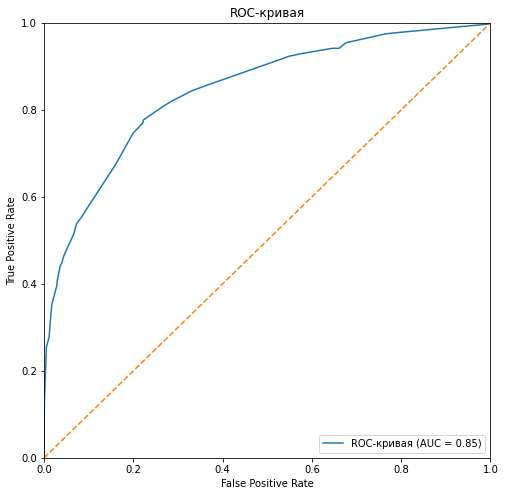

In [18]:
model = DecisionTreeClassifier(max_depth = best_depth,
                               min_samples_split = best_split,
                               min_samples_leaf = best_leaf,
                               random_state = 123) 
model.fit(features_train, target_train) 
predictions = model.predict(features_valid)

f1 = f1_score(target_valid, predictions)
 
print("F1-мера:", f1)
roc_auc_fig(model)

Так же проверям случайный лес

In [19]:
param_grid = {
    'n_estimators': range(10,20,2),
    'max_depth' : range(1,10),
    'min_samples_split' : range(2,6),
    'min_samples_leaf' : range(1,6)
}

grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state = 123), 
                           param_grid = param_grid, 
                           scoring = 'f1', 
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

grid_search.fit(features_train, target_train)

best_estimators = grid_search.best_params_['n_estimators']
best_depth = grid_search.best_params_['max_depth']
best_split = grid_search.best_params_['min_samples_split']
best_leaf = grid_search.best_params_['min_samples_leaf']

print('Best f1_score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best f1_score: 0.5591035541596487
Best parameters: {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 12}


F1-мера: 0.5589660743134087


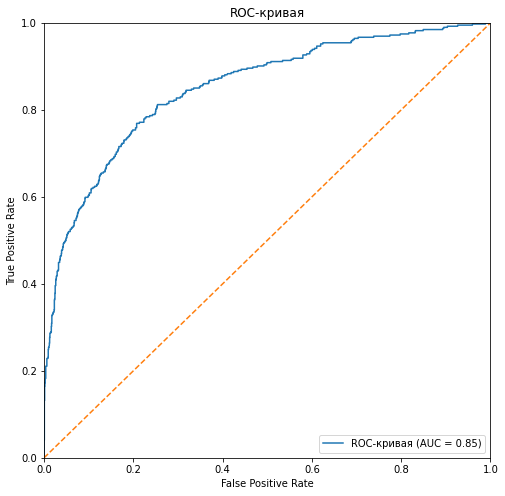

In [20]:
model = RandomForestClassifier(n_estimators = best_estimators,
                               max_depth = best_depth,
                               min_samples_split = best_split,
                               min_samples_leaf = best_leaf,
                               random_state = 123) 
model.fit(features_train, target_train) 
predictions = model.predict(features_valid)

f1 = f1_score(target_valid, predictions)
 
print("F1-мера:", f1)
roc_auc_fig(model)

###### Итоги:
  1. Дерево решений. С помощью функции GridSearchCV выявили лучшую модель для дерева решений, обучили модель на лучших параметрах и проверили ее на валидационной выборке:
- F1-мера = 0.5492730210016155 
- ROC-AUC = 0.85


  2. Случайный лес. С помощью функции GridSearchCV выявили лучшую модель для случайного леса, обучили модель на лучших параметрах и проверили ее на валидационной выборке:
- F1-мера = 0.5589660743134087
- ROC-AUC = 0.85 

## Борьба с дисбалансом

Посмотрим на дисбаланс классов

0    0.7963
1    0.2037
Name: exited, dtype: float64


<AxesSubplot:>

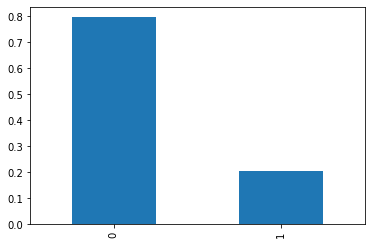

In [21]:
class_frequency = df_ohe['exited'].value_counts(normalize = True)
print(class_frequency)
class_frequency.plot(kind = 'bar')

Дерево решений. Произведем взвешивание классов с помощью параметра c 'class_weight' и проверим результаты f1 меры 

In [22]:
param_grid = {
    'max_depth' : range(1,20),
    'min_samples_split' : range(2,6),
    'min_samples_leaf' : range(1,6)
}

grid_search = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 123, class_weight = 'balanced'), 
                           param_grid = param_grid, 
                           scoring = 'f1', 
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

grid_search.fit(features_train, target_train)

best_depth = grid_search.best_params_['max_depth']
best_split = grid_search.best_params_['min_samples_split']
best_leaf = grid_search.best_params_['min_samples_leaf']

print('Best f1_score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

Fitting 5 folds for each of 380 candidates, totalling 1900 fits
Best f1_score: 0.5625586901235774
Best parameters: {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2}


F1-мера: 0.5646196150320807


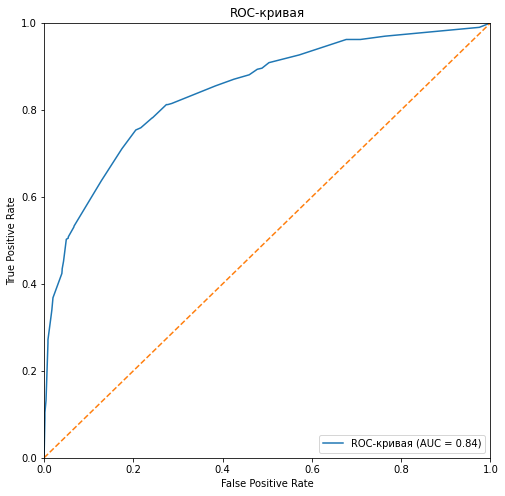

In [23]:
model = DecisionTreeClassifier(max_depth = best_depth,
                               min_samples_split = best_split,
                               min_samples_leaf = best_leaf,
                               random_state = 123,
                               class_weight = 'balanced') 
model.fit(features_train, target_train) 
predictions = model.predict(features_valid)

f1 = f1_score(target_valid, predictions)
 
print("F1-мера:", f1)
roc_auc_fig(model)

Случайный лес. Произведем взвешивание классов с помощью параметра c 'class_weight' и проверим результаты f1 меры 

In [24]:
param_grid = {
    'n_estimators': range(10,20,2),
    'max_depth' : range(1,10),
    'min_samples_split' : range(2,6),
    'min_samples_leaf' : range(1,6)
}

grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state = 123, class_weight = 'balanced'), 
                           param_grid = param_grid, 
                           scoring = 'f1', 
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

grid_search.fit(features_train, target_train)

best_estimators = grid_search.best_params_['n_estimators']
best_depth = grid_search.best_params_['max_depth']
best_split = grid_search.best_params_['min_samples_split']
best_leaf = grid_search.best_params_['min_samples_leaf']

print('Best f1_score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best f1_score: 0.607345719849069
Best parameters: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 12}


F1-мера: 0.5986984815618221


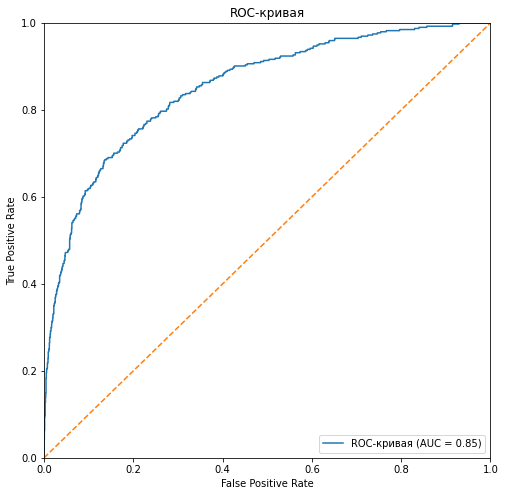

In [25]:
model = RandomForestClassifier(n_estimators = best_estimators,
                               max_depth = best_depth,
                               min_samples_split = best_split,
                               min_samples_leaf = best_leaf,
                               random_state = 123,
                               class_weight = 'balanced') 
model.fit(features_train, target_train) 
predictions = model.predict(features_valid)

f1 = f1_score(target_valid, predictions)
 
print("F1-мера:", f1)
roc_auc_fig(model)

###### Итоги:
  1. Дерево решений. С помощью функции GridSearchCV и взвешивании классов выявили лучшую модель для дерева решений, обучили модель на лучших параметрах и проверили ее на валидационной выборке:
- F1-мера = 0.5639589169000933
- ROC-AUC = 0.84


  2. Случайный лес. С помощью функции GridSearchCV и взвешивании классов выявили лучшую модель для случайного леса, обучили модель на лучших параметрах и проверили ее на валидационной выборке:
- F1-мера = 0.5986984815618221
- ROC-AUC = 0.85 

Увеличение и уменьшение выборки с помощью функции 'resample'

Подготовим тренировочный датасет для уменьшения и увеличения выборки

In [26]:
df_train_down = pd.concat([features_train, target_train], axis=1)  

df_majority = df_train_down[df_train_down['exited']==0]
df_minority = df_train_down[df_train_down['exited']==1]

df_majority_downsampled = resample(df_majority,
                                   replace=False,     
                                   n_samples=len(df_minority), 
                                   random_state=123)  

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

features_train_downsampled = df_downsampled.drop('exited', axis=1)
target_train_downsampled = df_downsampled['exited']

features_train_downsampled, target_train_downsampled = shuffle(features_train_downsampled, target_train_downsampled, random_state=123)

print(target_train_downsampled.value_counts())

0    1239
1    1239
Name: exited, dtype: int64


In [27]:
df_train_up = pd.concat([features_train, target_train], axis=1)  

df_majority = df_train_up[df_train_up['exited']==0]
df_minority = df_train_up[df_train_up['exited']==1]

df_minority_upsampled = resample(df_minority,
                                 replace=True,     
                                 n_samples=len(df_majority), 
                                 random_state=123)  

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

target_train_upsampled = df_upsampled['exited']
features_train_upsampled = df_upsampled.drop('exited', axis=1)

features_train_upsampled, target_train_upsampled = shuffle(features_train_upsampled, target_train_upsampled, random_state=123)

print(target_train_upsampled.value_counts()) 

0    4761
1    4761
Name: exited, dtype: int64


Проверяем лучшие параметры с помощью GrindSearch для дерева решений уменьшенной и увеличеннной выборки 

1. Дерево решений - Увеличенная выборка

In [28]:
param_grid = {
    'max_depth' : range(1,20),
    'min_samples_split' : range(2,6),
    'min_samples_leaf' : range(1,6)
}

grid_search = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 123), 
                           param_grid = param_grid, 
                           scoring = 'f1', 
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

grid_search.fit(features_train_upsampled, target_train_upsampled)

best_depth = grid_search.best_params_['max_depth']
best_split = grid_search.best_params_['min_samples_split']
best_leaf = grid_search.best_params_['min_samples_leaf']

print('Best f1_score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

Fitting 5 folds for each of 380 candidates, totalling 1900 fits
Best f1_score: 0.9180406563884015
Best parameters: {'max_depth': 19, 'min_samples_leaf': 1, 'min_samples_split': 2}


F1-мера: 0.4810126582278481


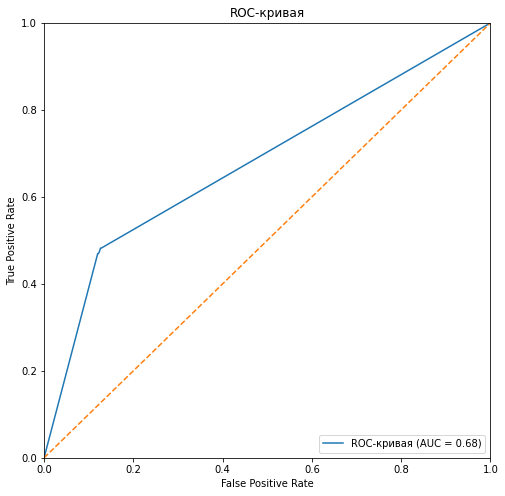

In [29]:
model = DecisionTreeClassifier(max_depth = best_depth,
                               min_samples_split = best_split,
                               min_samples_leaf = best_leaf,
                               random_state = 123) 
model.fit(features_train_upsampled, target_train_upsampled) 
predictions = model.predict(features_valid)

f1 = f1_score(target_valid, predictions)
 
print("F1-мера:", f1)
roc_auc_fig(model)

2. Дерево решений - Уменьшенная выборка

In [30]:
param_grid = {
    'max_depth' : range(1,20),
    'min_samples_split' : range(2,6),
    'min_samples_leaf' : range(1,6)
}

grid_search = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 123), 
                           param_grid = param_grid, 
                           scoring = 'f1', 
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

grid_search.fit(features_train_downsampled, target_train_downsampled)

best_depth = grid_search.best_params_['max_depth']
best_split = grid_search.best_params_['min_samples_split']
best_leaf = grid_search.best_params_['min_samples_leaf']

print('Best f1_score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

Fitting 5 folds for each of 380 candidates, totalling 1900 fits
Best f1_score: 0.7568903523126205
Best parameters: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}


F1-мера: 0.5642407906558851


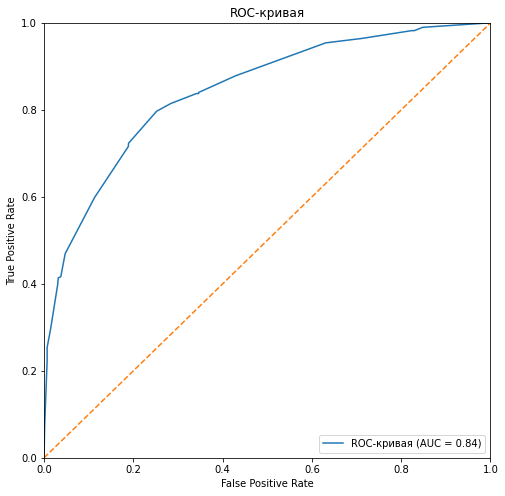

In [31]:
model = DecisionTreeClassifier(max_depth = best_depth,
                               min_samples_split = best_split,
                               min_samples_leaf = best_leaf,
                               random_state = 123) 
model.fit(features_train_downsampled, target_train_downsampled) 
predictions = model.predict(features_valid)

f1 = f1_score(target_valid, predictions)
 
print("F1-мера:", f1)
roc_auc_fig(model)

Проверяем параметры и f1 меру для Случайного леса с помощью увеличенной и уменьшенной вборки 

3. Случайный лес - Увеличенная выборка

In [32]:
param_grid = {
    'n_estimators': range(10,20,2),
    'max_depth' : range(1,10),
    'min_samples_split' : range(2,6),
    'min_samples_leaf' : range(1,6)
}

grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state = 123), 
                           param_grid = param_grid, 
                           scoring = 'f1', 
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

grid_search.fit(features_train_upsampled, target_train_upsampled)

best_estimators = grid_search.best_params_['n_estimators']
best_depth = grid_search.best_params_['max_depth']
best_split = grid_search.best_params_['min_samples_split']
best_leaf = grid_search.best_params_['min_samples_leaf']

print('Best f1_score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best f1_score: 0.844762760059339
Best parameters: {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 18}


F1-мера: 0.6027088036117382


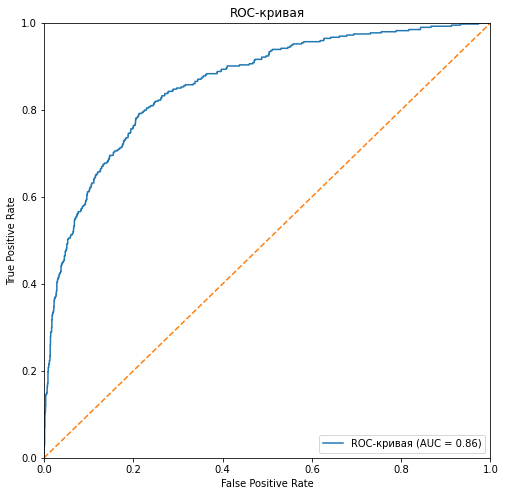

In [33]:
model = RandomForestClassifier(n_estimators = best_estimators,
                               max_depth = best_depth,
                               min_samples_split = best_split,
                               min_samples_leaf = best_leaf,
                               random_state = 123) 
model.fit(features_train_upsampled, target_train_upsampled) 
predictions = model.predict(features_valid)

f1 = f1_score(target_valid, predictions)
 
print("F1-мера:", f1)
roc_auc_fig(model)

4. Случайный лес - Уменьшенная выборка

In [34]:
param_grid = {
    'n_estimators': range(10,20,2),
    'max_depth' : range(1,10),
    'min_samples_split' : range(2,6),
    'min_samples_leaf' : range(1,6)
}

grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state = 123), 
                           param_grid = param_grid, 
                           scoring = 'f1', 
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

grid_search.fit(features_train_downsampled, target_train_downsampled)

best_estimators = grid_search.best_params_['n_estimators']
best_depth = grid_search.best_params_['max_depth']
best_split = grid_search.best_params_['min_samples_split']
best_leaf = grid_search.best_params_['min_samples_leaf']

print('Best f1_score:', grid_search.best_score_)
print('Best parameters:', grid_search.best_params_)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best f1_score: 0.7610841526612542
Best parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 16}


F1-мера: 0.5902293120638086


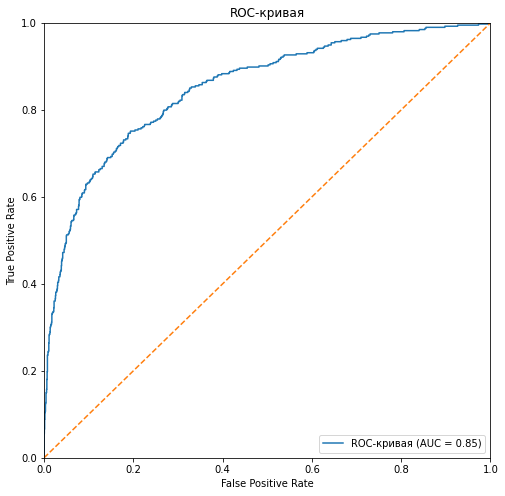

In [35]:
model = RandomForestClassifier(n_estimators = best_estimators,
                               max_depth = best_depth,
                               min_samples_split = best_split,
                               min_samples_leaf = best_leaf,
                               random_state = 123) 
model.fit(features_train_downsampled, target_train_downsampled) 
predictions = model.predict(features_valid)

f1 = f1_score(target_valid, predictions)
 
print("F1-мера:", f1)
roc_auc_fig(model)

###### Итоги:
  1. Дерево решений - увеличенная выборка:
- F1-мера = 0.4881693648816937
- ROC-AUC = 0.68


  2. Дерево решений - уменьшенная выборка:
- F1-мера = 0.5637342908438061
- ROC-AUC = 0.84


  3. Случайный лес - увеличенная выборка:
- F1-мера = 0.6027088036117382 (наилучший результат)
- ROC-AUC = 0.86


  4. Случайный лес - уменьшенная выборка:
- F1-мера = 0.5772200772200772
- ROC-AUC = 0.85

Все модели хорошо показывают себя во время обучения, однако на валидационной выборки значения значительно проваливаются 

Рекомендация: как ещё одна возможная альтернатива - использовать SMOTE (статьи: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html или https://habr.com/ru/articles/461285/) для увеличения выборки и RandomUnderSampler (статья: https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html) либо вместо (либо в дополнении) к функциям из тренажера.

## Тестирование модели

Будем тестировать две лучшие модели которые превзошли заданный порог r1 меру в 0.59

1. Случайный лес, взвешивание классов

f1_score: 0.6086956521739131


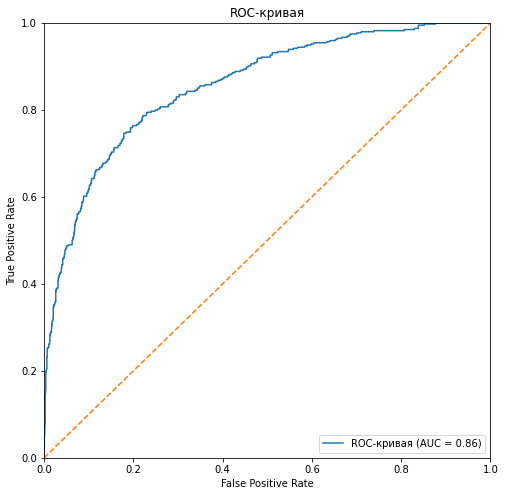

In [39]:
model = RandomForestClassifier(n_estimators = 12,
                                    max_depth = 8,
                                    min_samples_leaf = 5, 
                                    min_samples_split = 2,
                                    random_state=123,
                                    class_weight='balanced')

model.fit(features_train, target_train) 
predictions = model.predict(features_test)
f1 = f1_score(target_test, predictions)

print("f1_score:", f1)
roc_auc_fig(model)

2. Случайный лес, увеличение выборки

f1_score: 0.6152125279642058


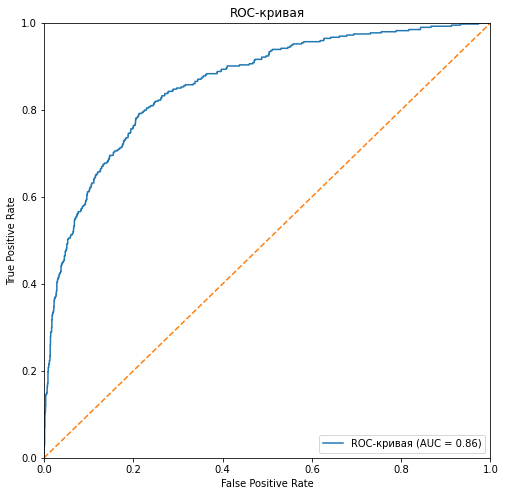

In [38]:
model = RandomForestClassifier(n_estimators = 18,
                               max_depth = 9,
                               min_samples_split = 3,
                               min_samples_leaf = 1,
                               random_state = 123) 
model.fit(features_train_upsampled, target_train_upsampled) 
predictions = model.predict(features_test)

f1 = f1_score(target_test, predictions)
 
print("f1_score:", f1)
roc_auc_fig(model)

###### Итоги:
Лучшие две модели которые превышают заданую f1 меру в 0.59:
    
1. Случайный лес, взвешивание классов
     - f1_score: 0.6086956521739131
     - ROC-AUC: 0.85
     
     
     
2. Случайный лес, увеличение выборки
     - f1_score: 0.6152125279642058
     - ROC-AUC: 0.86
         


# Итог:
    

***Подготовка данных:***
- Провели первичную обработку данных
- Привели названия столбцов к норме
- Проверили наличие дубликатов 
- Заменили пропущенные значения в столбце 'tenure'
- Привели категориальные признаки к числовым значениям прямым кодированием
- Разбили датасет на 3 выборки: тренировочную, валидационную, тестовую 
- Стандартизировали данные

***Исследование задачи***
  1. С помощью функции GridSearchCV выявили лучшую модель для дерева решений, обучили модель на лучших параметрах и проверили ее на валидационной выборке:
- F1-мера = 0.5492730210016155
- ROC-AUC = 0.85


  2. С помощью функции GridSearchCV выявили лучшую модель для случайного леса, обучили модель на лучших параметрах и проверили ее на валидационной выборке:
- F1-мера = 0.5589660743134087
- ROC-AUC = 0.85


***Взвешивание классов***

  1. С помощью функции GridSearchCV и взвешивании классов выявили лучшую модель для дерева решений, обучили модель на лучших параметрах и проверили ее на валидационной выборке:
- F1-мера = 0.5639589169000933
- ROC-AUC = 0.84


  2. С помощью функции GridSearchCV и взвешивании классов выявили лучшую модель для случайного леса, обучили модель на лучших параметрах и проверили ее на валидационной выборке:
- F1-мера = 0.5986984815618221  
- ROC-AUC = 0.85

***Увеличение и уменьшение выборки***

С помощью увеличения и уменьшения выборок, провели анализ данных:

  1. Дерево решений - увеличенная выборка:
- F1-мера = 0.4881693648816937
- ROC-AUC = 0.68


  2. Дерево решений - уменьшенная выборка:
- F1-мера = 0.5637342908438061
- ROC-AUC = 0.84


  3. Случайный лес - увеличенная выборка:
- F1-мера = 0.6027088036117382 (наилучший результат)
- ROC-AUC = 0.86


  4. Случайный лес - уменьшенная выборка:
- F1-мера = 0.5772200772200772
- ROC-AUC = 0.85

Все модели хорошо показывают себя во время обучения, однако на валидационной выборки значения значительно проваливаются



****Тестирование****

Лучшие две модели по прошлому анализу которые превышают заданую f1 меру в 0.59 прогнали через тестовые выборки и получили такие результаты:
    
- ***Случайный лес, взвешивание классов***
     - f1_score: 0.6086956521739131
     - ROC-AUC: 0.85
     
     
     
- ***Случайный лес, увеличение выборки***
     - f1_score: 0.6152125279642058
     - ROC-AUC: 0.86
         
Наилучшая модель = Случайный лес с параметрами: 'n_estimators' = 18, 'max_depth' = 9, 'min_samples_split' = 3, 'min_samples_leaf' = 1) и увеличенной выборкой.